# Event frequency
## Get the data


In [1]:
# builds the connection to azure:
%matplotlib inline

import os
import sys

import numpy as np

import seaborn as sns

# import custom modules:
module_path = os.path.dirname(os.path.abspath(''))
if module_path not in sys.path:
    sys.path.append(module_path)
from common.get_data import *

#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


In [2]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

## Get model data

In [3]:
# get model_data
df_model = pd.read_sql_query('''
    select
        run_id::text as entity,
        count(*)::float/10000 as frequency,
        'Model_events' as source
    from
        model_events
    group by run_id::text
''', engine)
df_model.tail()

,entity,frequency,source
944,modelchangesflow-fortune-0995-v2022.2.3-2022-0...,0.4765,Model_events
945,modelchangesflow-fortune-0996-v2022.2.3-2022-0...,0.3840,Model_events
946,modelchangesflow-fortune-0998-v2022.2.3-2022-0...,0.3127,Model_events
947,modelchangesflow-fortune-0999-v2022.2.3-2022-0...,0.4718,Model_events
948,modelchangesflow-fortune-1000-v2022.2.3-2022-0...,0.8077,Model_events


## Get Events data

[TBC convert to by company by year]

In [4]:
df_events = read_f1k_table()
df_events['year'] = df_events['event_start_date'].dt.year
df_events = (df_events.groupby('year').agg({'event_id':'count'})/1000).rename({'event_id':'frequency'}, axis='columns').reset_index()
df_events['source']='events'
df_events

,year,frequency,source
0,2010,0.121,events
1,2011,0.183,events
2,2012,0.201,events
3,2013,0.384,events
4,2014,0.405,events
5,2015,0.453,events
6,2016,0.601,events
7,2017,0.534,events
8,2018,0.343,events
9,2019,0.242,events


## Compare overall frequency

Text(0.5, 1.0, 'v2022.2.3')

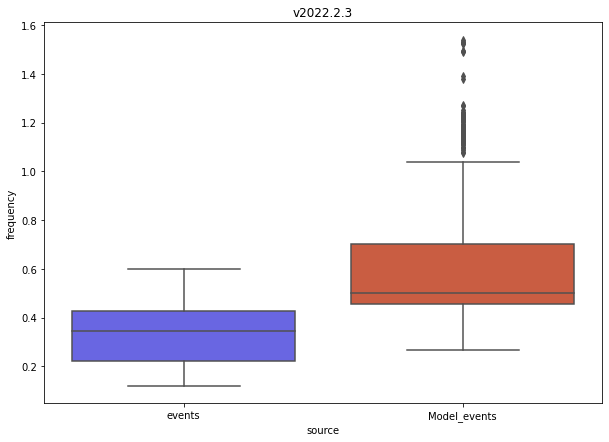

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
df_plot = pd.concat([df_events[['year','frequency', 'source']],
                     df_model[['entity','frequency', 'source']]])

sns.boxplot(data=df_plot, x='source', y='frequency')
ax.set_title(model_version)

# Split out event_type composition


In [61]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *


init_notebook_mode(connected=True)         # initiate notebook for offline plot


## Model

In [77]:
# get model_data
df_model = pd.read_sql_query('''
    select
        confidentiality,
        availability,
        integrity,
        extortion
        event_type,
        targeted_event_type,
        1 as count
    from
        model_events
''', engine)
df_model.tail()



,confidentiality,availability,integrity,event_type,targeted_event_type,count
5694063,1,1,0,0,data_breach,1
5694064,1,1,0,0,data_breach,1
5694065,1,1,0,0,data_breach,1
5694066,1,1,0,0,data_breach,1
5694067,1,1,0,0,data_breach,1


In [78]:
#setup labels to use
df_model_et = df_model.copy()
df_model_et['confidentiality'] = df_model_et['confidentiality'].replace(1, 'confidentiality impacted')
df_model_et['confidentiality'] = df_model_et['confidentiality'].replace(0, 'no confidential impact')

df_model_et['event_type'] = df_model_et['event_type'].replace('provider', 'systemic')
df_model_et['event_type'] = df_model_et['event_type'].replace('tech', 'systemic')

df_model_et['targeted_event_type'] = df_model_et['targeted_event_type'].fillna('systemic')
df_model_et['targeted_event_type'] = df_model_et['targeted_event_type'].replace('service_provider_data_breach', 'data_breach')
df_model_et['targeted_event_type'] = df_model_et['targeted_event_type'].replace('service_provider_interruption', 'interruption')
df_model_et['targeted_event_type'].unique()


array(['data_breach', 'systemic', 'interruption', 'ransomware'],
      dtype=object)

In [79]:
index_cols = ['confidentiality', 'targeted_event_type']
target_col = 'count'

def build_sankey(index_cols, target_col, df):
    input_df = df.copy()

    # build target/source relationships
    df_links = pd.DataFrame()
    for pos in range(0,len(index_cols)-1):
        temp_df = input_df.groupby([index_cols[pos], index_cols[pos+1]]).agg({target_col:'sum'}).reset_index()
        temp_df.columns = ['source', 'target', 'value']
        df_links = pd.concat([df_links, temp_df])
    df_links['value'] = (df_links['value']/df_links['value'].sum())

    # label encoding:
    label_list = list(df_links['source'])
    label_list.extend(list(df_links['target']))
    label_list = list(dict.fromkeys(label_list))
    label_dict = {}
    i=0
    for item in label_list:
        label_dict[item] = i
        i+=1
    label_dict

    df_links['source'] = df_links['source'].replace(label_dict)
    df_links['target'] = df_links['target'].replace(label_dict)

    return df_links, label_dict

df_links, label_dict = build_sankey(index_cols, target_col, df_model_et)

In [80]:
df_links = df_links.copy()

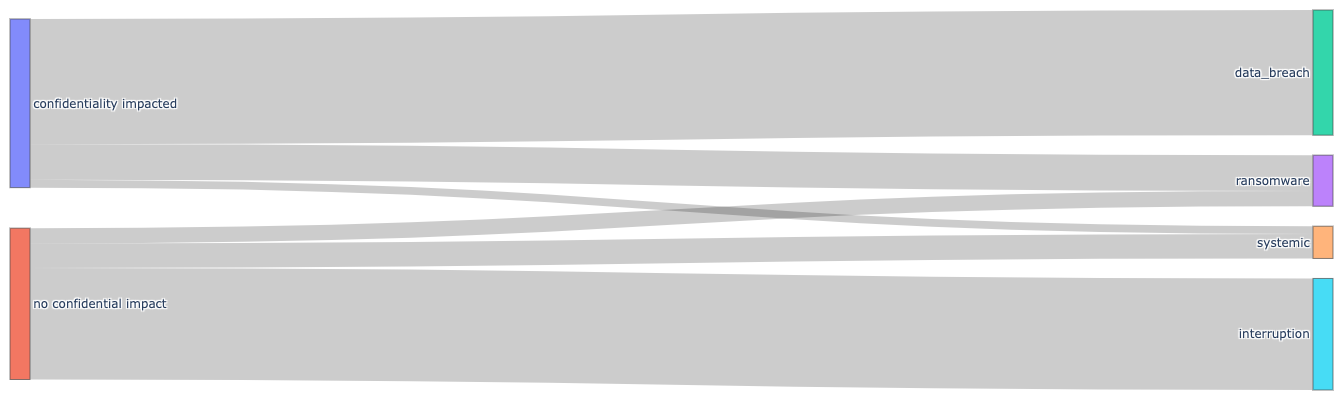

In [81]:
fig = go.Figure(
    go.Sankey(
        node={"label": list(label_dict.keys())},
        link={
            "source": df_links['source'].values,
            "target": df_links['target'].values,
            "value" : df_links['value'].values,
        },
    )
)

fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    width=400,
    height=400
)

fig.show()

## Events

In [82]:
# get event data
df_events = pd.read_sql_query('''
    select
        impact_type_confidentiality,
        impact_type_availability,
        impact_type_integrity,
        event_type,
        1 as count
    from
        data_sources_events
''', engine)
df_events.tail()

df_events['impact_type_confidentiality'] = df_events['impact_type_confidentiality'].replace(True, 'confidentiality impacted')
df_events['impact_type_confidentiality'] = df_events['impact_type_confidentiality'].replace(False, 'no confidentiality impact')


In [83]:
event_map = {"['Data Breach']":'data breach',
             "['Infrastructure Attack']":'infrastructure attack',
             "['Financial Theft']":'financial',
             "['Ransomware']":'ransomware',
             "['Interruption']":'interruption',
             "['Ransomware' 'Data Breach']":'ransomware',
             "['Data Breach' 'Ransomware']":'ransomware',
             "['Data Breach' 'Financial Theft']":'data breach',
             "['Data Breach' 'Interruption']":'data breach',
             "['Ransomware' 'Interruption']":'ransomware',
             "['Infrastructure Attack' 'Data Breach']":'data breach',
             "['Data Breach' 'Ransomware' 'Interruption']":'ransomware',
             "['Data Breach' 'Interruption' 'Ransomware']":'ransomware',
             None:'unknown',
              }
df_events['event_type'] = df_events['event_type'].replace(event_map)
list(df_events['event_type'].unique())

['data breach',
 'infrastructure attack',
 'financial',
 'ransomware',
 'interruption',
 'None']

In [84]:
df_links, label_dict = build_sankey(['impact_type_confidentiality','event_type'], 'count', df_events)

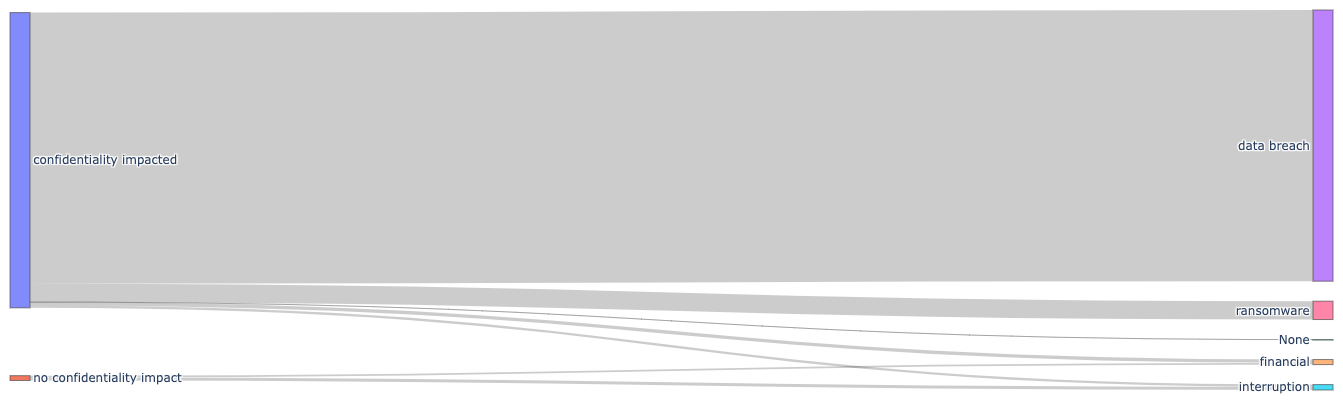

In [85]:
fig = go.Figure(
    go.Sankey(
        node={"label": list(label_dict.keys())},
        link={
            "source": df_links['source'],
            "target": df_links['target'],
            "value" : df_links['value'],
        },
    )
)

fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    width=400,
    height=400
)

fig.show()

# Split CIA Composition


## Model

In [93]:
df_model_cia = df_model.copy()
df_model_cia['confidentiality'] = df_model_cia['confidentiality'].replace(1, 'confidentiality')
df_model_cia['confidentiality'] = df_model_cia['confidentiality'].replace(0, 'no confidentiality impact')
df_model_cia['availability'] = df_model_cia['availability'].replace(1, 'availability')
df_model_cia['availability'] = df_model_cia['availability'].replace(0, 'no availability impact')
df_model_cia['integrity'] = df_model_cia['integrity'].replace(1, 'integrity')
df_model_cia['integrity'] = df_model_cia['integrity'].replace(0, 'no integrity impact')

df_links, label_dict = build_sankey(['confidentiality','availability', 'integrity'], 'count', df_model_cia)

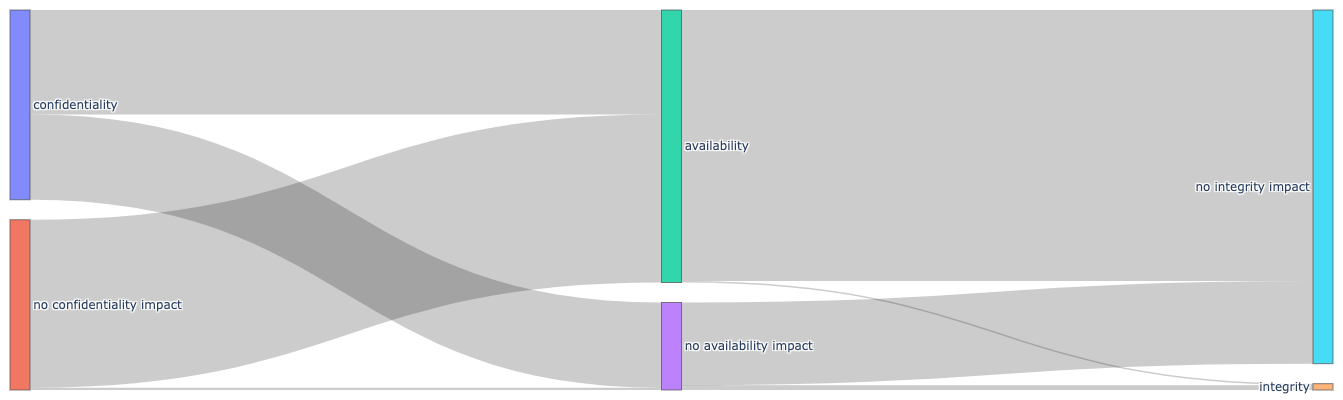

In [94]:
fig = go.Figure(
    go.Sankey(
        node={"label": list(label_dict.keys())},
        link={
            "source": df_links['source'],
            "target": df_links['target'],
            "value" : df_links['value'],
        },
    )
)

fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    width=400,
    height=400
)

fig.show()

### model percentage CIA split

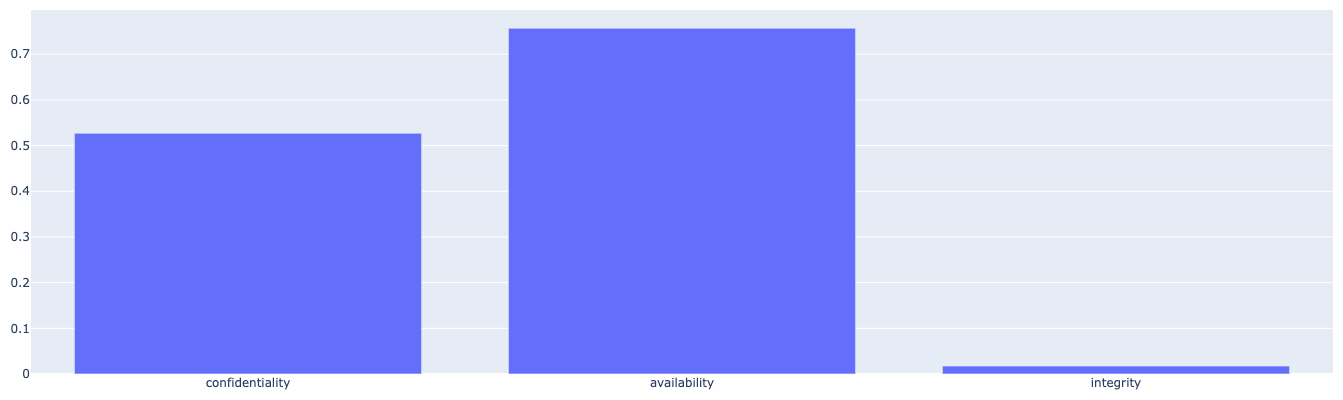

In [92]:
cia_bar_model = df_model[['confidentiality', 'availability', 'integrity']].sum()/len(df_model)
fig = go.Figure(
    go.Bar(
        x=cia_bar_model.index,
        y=cia_bar_model.values
    )
)

fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    width=400,
    height=400
)

fig.show()

## events

In [73]:
df_events_cia = df_events.copy()
df_events_cia['impact_type_confidentiality'] = df_events_cia['impact_type_confidentiality'].replace(1, 'confidentiality')
df_events_cia['impact_type_confidentiality'] = df_events_cia['impact_type_confidentiality'].replace(0, 'none')
df_events_cia['impact_type_confidentiality'] = df_events_cia['impact_type_confidentiality'].fillna('c - unknown')

df_events_cia['impact_type_availability'] = df_events_cia['impact_type_availability'].replace(1, 'availability')
df_events_cia['impact_type_availability'] = df_events_cia['impact_type_availability'].replace(0, 'no availability impact')
df_events_cia['impact_type_availability'] = df_events_cia['impact_type_availability'].fillna('a - unknown')

df_events_cia['impact_type_integrity'] = df_events_cia['impact_type_integrity'].replace(1, 'integrity')
df_events_cia['impact_type_integrity'] = df_events_cia['impact_type_integrity'].replace(0, 'no integrity impact')
df_events_cia['impact_type_integrity'] = df_events_cia['impact_type_integrity'].fillna('i - unknown')

df_links, label_dict = build_sankey(['impact_type_confidentiality','impact_type_availability', 'impact_type_integrity'], 'count', df_events_cia)

In [74]:
df_events_cia['impact_type_confidentiality'].unique()

array(['confidentiality impacted', 'c - unknown',
       'no confidentiality impact'], dtype=object)

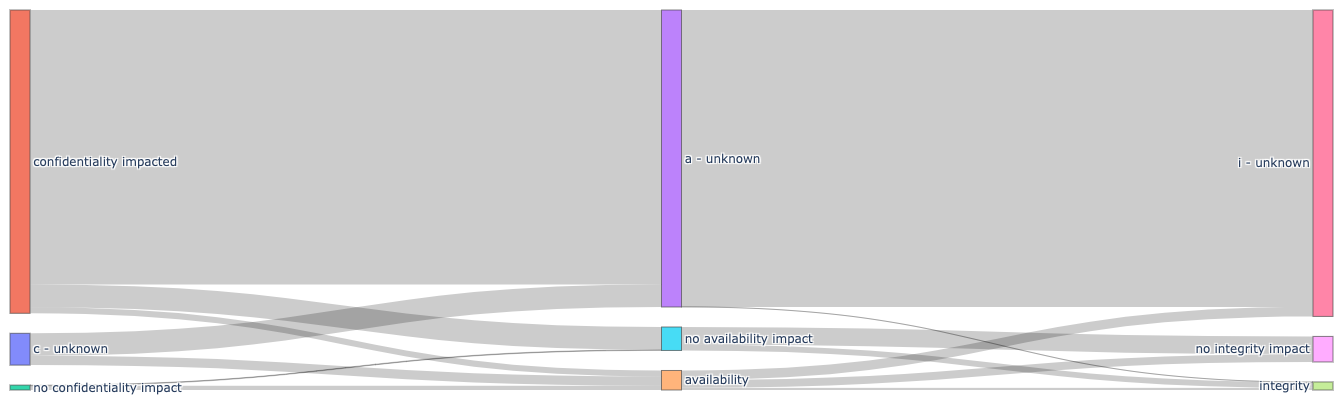

In [75]:
fig = go.Figure(
    go.Sankey(
        node={"label": list(label_dict.keys())},
        link={
            "source": df_links['source'],
            "target": df_links['target'],
            "value" : df_links['value'],
        },
    )
)

fig.update_layout(
    margin=dict(l=10, r=10, t=10, b=10),
    width=600,
    height=400
)

fig.show()